In [1]:
%config IPCompleter.greedy=True
import cvxpy as cp
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import PIL.Image
import time
print('CVXPY version: ', cp.__version__)
print('CVXPY solvers: ', cp.installed_solvers())

CVXPY version:  1.0.21
CVXPY solvers:  ['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'XPRESS', 'GLPK_MI', 'CBC', 'SCS', 'GUROBI', 'OSQP', 'GUROBI']


In [2]:
# load pretrained model   
model = tf.keras.models.load_model('gtsrb_01_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
NOF_CLASSES = 43
LAYER_LEN = [4800, 512, NOF_CLASSES]
IMG_SHAPE = (40, 40, 3)
MARGIN = 5
# indices of red channels of inner pixels
ridx = np.array([120*i+3*j for i in range(MARGIN, IMG_SHAPE[0]-MARGIN) for j in range(MARGIN, IMG_SHAPE[1]-MARGIN)])

In [4]:
bw = [None, np.zeros((LAYER_LEN[0]+1,LAYER_LEN[1])), np.zeros((LAYER_LEN[1]+1,LAYER_LEN[2]))]  # "biased weights"
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()  # list of numpy arrays
#     print(f'keras layer[{i}] {layer.name} weights nparrays: {len(weights)}')
    if i in [1, 3]:
        icorr = i//2 + 1
#         print(f'layer{icorr} weights: {weights[0].shape} and {weights[1].shape}')
        bw[icorr] = np.vstack((weights[0], weights[1]))
        print(f'resulting bw[{icorr}]: {bw[icorr].shape}')

resulting bw[1]: (4801, 512)
resulting bw[2]: (513, 43)


In [13]:
# SPECIFICATIONS: rule names, input subsets and expected output classes
NOF_PX = (IMG_SHAPE[0]-2*MARGIN) * (IMG_SHAPE[1]-2*MARGIN)  # 900 by default

specification_names = {
    'l_r':  'Linear Redness Score          ',
    'l_g':  'Linear Greenness Score        ',
    'l_b':  'Linear Blueness Score         ',
    'l_y':  'Linear Yellowness Score       ',
    'l_m':  'Linear Magentaness Score      ',
    'l_c':  'Linear Cyanness Score         ',
    'l_dr': 'Linear Dark Redness Score     ',
    'l_dg': 'Linear Dark Greenness Score   ',
    'l_db': 'Linear Dark Blueness Score    ',
    'l_ly': 'Linear Light Yellowness Score ',
    'l_lm': 'Linear Light Magentaness Score',
    'l_lc': 'Linear Light Cyanness Score   ',
    'l_rg': 'Linear Red-Greenness Score    ',
    'l_rb': 'Linear Red-Blueness Score     ',
    'l_gb': 'Linear Green-Blueness Score   ',
    'l_in': 'Linear Intensity Score        '
}

specified_input = {
    'l_r':  lambda r,g,b: (1/2 + cp.sum(2*r-g-b)/(255*NOF_PX*4)) <= 0.4398, # 0.4398,
    'l_g':  lambda r,g,b: (1/2 + cp.sum(2*g-r-b)/(255*NOF_PX*4)) <= 0, # 0.4721,
    'l_b':  lambda r,g,b: (1/2 + cp.sum(2*b-r-g)/(255*NOF_PX*4)) >= 1, # 0.5715,
    'l_y':  lambda r,g,b: (1/2 + cp.sum(r+g-2*b)/(255*NOF_PX*4)) <= 0, # 0.4323,
    'l_m':  lambda r,g,b: (1/2 + cp.sum(r+b-2*g)/(255*NOF_PX*4)) <= 0, # 0.5001,
    'l_c':  lambda r,g,b: (1/2 + cp.sum(g+b-2*r)/(255*NOF_PX*4)) >= 1, # 0.5438,
    'l_dr': lambda r,g,b: (1 + cp.sum(-g-b)/(255*NOF_PX*2))      >= 1, # 0.9261,
    'l_dg': lambda r,g,b: (1 + cp.sum(-r-b)/(255*NOF_PX*2))      >= 1, # 0.9243,
    'l_db': lambda r,g,b: (1 + cp.sum(-r-g)/(255*NOF_PX*2))      >= 1, # 0.9274,
    'l_ly': lambda r,g,b: (cp.sum(r+g)/(255*NOF_PX*2))           <= 0, # 0.0658,
    'l_lm': lambda r,g,b: (cp.sum(r+b)/(255*NOF_PX*2))           <= 0, # 0.0757,
    'l_lc': lambda r,g,b: (cp.sum(g+b)/(255*NOF_PX*2))           <= 0, # 0.0804,
    'l_rg': lambda r,g,b: (1 - cp.sum(b)/(255*NOF_PX))           >= 1, # 0.9177,
    'l_rb': lambda r,g,b: (1 - cp.sum(g)/(255*NOF_PX))           >= 1, # 0.9339,
    'l_gb': lambda r,g,b: (1 - cp.sum(r)/(255*NOF_PX))           >= 1, # 0.9295,
    'l_in': lambda r,g,b: (cp.sum(r+g+b)/(255*NOF_PX*3))         <= 0 # 0.0713
}

expected_outs = {
    'l_r':  range(33, 41),
    'l_g':  [c for c in range(NOF_CLASSES) if c not in [32, 19, 20, 37, 6, 41, 42, 12, 31]],
    'l_b':  range(33, 42),
    'l_y':  range(33, 42),
    'l_m':  [c for c in range(NOF_CLASSES) if c not in [0, 33, 5, 8, 9, 10, 14, 15, 17, 19, 24, 27, 29, 30]],
    'l_c':  [c for c in range(NOF_CLASSES) if c not in [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 42]],
    'l_dr': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 6, 40, 41, 42, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29]],
    'l_dg': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 40, 41, 42, 11, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29, 30]],
    'l_db': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 36, 37, 40, 41, 11, 14, 15, 21, 22, 24, 27, 28, 29]],
    'l_ly': [c for c in range(NOF_CLASSES) if c not in [0, 32, 1, 2, 34, 36, 37, 6, 40, 41, 42, 11, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29, 30]],
    'l_lm': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 6, 40, 41, 42, 11, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29, 30]],
    'l_lc': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 40, 41, 42, 14, 15, 21, 22, 24, 27, 28, 29]],
    'l_rg': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 6, 39, 40, 41, 42, 14, 15, 20, 21, 22, 24, 27, 28, 29, 30]],
    'l_rb': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 36, 37, 6, 40, 41, 42, 11, 14, 15, 16, 21, 22, 24, 27, 28, 29]],
    'l_gb': [c for c in range(NOF_CLASSES) if c not in [0, 32, 1, 2, 34, 36, 37, 40, 41, 11, 14, 15, 16, 21, 22, 24, 27, 28, 29]],
    'l_in': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 6, 40, 41, 42, 11, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29, 30]]
}

specifications = list(zip(specification_names.values(), specified_input.values(), expected_outs.values()))

In [14]:
def verify(specification, BIG_M1 = 100000, BIG_M2 = 100000):    
    specifn_name = specification[0]
    specified_in = specification[1]
    expected_out = specification[2]
    # VARS
    l0a = cp.Variable(LAYER_LEN[0], integer=True)
    l1z = cp.Variable(LAYER_LEN[1])
    l1s = cp.Variable(LAYER_LEN[1], boolean=True)  # is ReLU active? (in the positive regime)
    l1a = cp.Variable(LAYER_LEN[1])
    l2z = cp.Variable(LAYER_LEN[2])
    # hmx vars
    adv_out = [c for c in range(NOF_CLASSES) if c not in expected_out]  # ADVERSARIAL output must fall into one of these
    hmx = cp.Variable(len(adv_out), boolean=True)  # is hardmax active for class hmx[k] out of K expected? NOTE DIFFERENT NUMBERING!

    # CONSTRAINTS
    constraints = []
    L = 0
    for i in range(LAYER_LEN[L]):
        constraints.append(l0a[i] >= 0)
        constraints.append(l0a[i] <= 255)
    L = 1
    for i in range(LAYER_LEN[L]):
        _dendrites = l0a * bw[L][:-1, i]
        _bias = bw[L][-1, i]
        constraints.append(l1z[i] == cp.sum(_dendrites) + _bias)
        constraints.append(l1a[i] >= 0)
        constraints.append(l1a[i] >= l1z[i])
        constraints.append(l1a[i] <= BIG_M1*l1s[i])
        constraints.append(l1a[i] <= l1z[i] + BIG_M1*(1-l1s[i]))
    L = 2
    for i in range(LAYER_LEN[L]):
        _dendrites = l1a * bw[L][:-1, i]
        _bias = bw[L][-1, i]
        constraints.append(l2z[i] == cp.sum(_dendrites) + _bias)

    # SPECIFICATION CONSTRAINTS
    # input features for specification
    r = l0a[ridx]  # red intensities within margin
    g = l0a[ridx+1]  # green intensities within margin
    b = l0a[ridx+2]  # blue intensities within margin
    l_r = (1/2 + (1/3600)*cp.sum(2*r-g-b)/255) <= 0.4398
    l_y = (1/2 + (1/3600)*cp.sum(r+g-2*b)/255) <= 0.4323

    # specified input
    constraints.append(specified_in(r,g,b))
    # specified output
    constraints.append(cp.sum(hmx) == 1)  # hardmax selects exactly one
    for k, i in enumerate(adv_out):
        for j in range(LAYER_LEN[2]):
            if i!=j:
                _d = l2z[i]-l2z[j]
                constraints.append(_d >= -BIG_M2 * (1-hmx[k]))  # the selected max must have all differences >= 0

    # OBJ
    obj = cp.Minimize(1)

    # PROBLEM
    prob = cp.Problem(obj, constraints)

    # SOLVE
    start = time.time()
    prob.solve(solver=cp.GUROBI, verbose=False)  # GLPK_MI, CBC, XPRESS, GUROBI
    end = time.time()
    
    print()
    print(f'Run time: ', end - start)
    print(f'{specifn_name} Rule falsified: {prob.status=="optimal"} \t Numerical stability: {checkWarrantedAdversarial() and checkUnsquashedAdversarial()}')
    img_arr = np.reshape(l0a.value, IMG_SHAPE).astype(np.uint8)
    display(PIL.Image.fromarray(img_arr))
    print_nonintegral()

In [15]:
# integrality checks: the solvers may find unwarranted "adversarials" bc of tolerance
# if no sol found: great! that means there are neither warranted nor unwarranted adversarials ==> VERIFIED.
# if sol found and integral: it is a warranted adversarial ==> FALSIFIED.
# if sol found but not integral: unwarranted adversarial: a real adversarial may still be out there
#   ==> tighten BIG_M or tolerance or try other solver
# see: http://www.gurobi.com/documentation/8.1/refman/numerics_dealing_with_big_.html
def checkWarrantedAdversarial():
    if prob.status == 'optimal':
        if np.flatnonzero(l0a.value%1).size>0:
            print_nonintegral()
            return False
        if (l1s.value[np.flatnonzero(l1s.value)] != 1).any():
            print_nonintegral()
            return False
        if (hmx.value[np.flatnonzero(hmx.value)] != 1).any():
            print_nonintegral()
            return False
    return True

# a too tight BIG_M could unnecessarily constrain/alter possible adversarials
# if that is the case, BIG_M must be adjusted regardless of whether a solution has been found or not
def checkUnsquashedAdversarial():
    if np.max(l1z.value) > BIG_M1:
        print(f'Squashed network at: l1z[{np.argmax(l1z.value)}]: {np.max(l1z.value)} > BIG_M1 == {BIG_M1}')
        return False
    if np.max(l2z.value)-np.min(l2z.value) > BIG_M2:
        print(f'Squashed network at: l2zDelta[{np.argmax(l2z.value)} vs {np.argmin(l2z.value)}]: '\
              +f'{np.max(l2z.value)-np.min(l2z.value)} > BIG_M2 == {BIG_M2}')
        return False
    return True

def print_nonintegral():
    l1s_neitheroff = l1s.value!=0
    l1s_neitheron = l1s.value!=1
    hmx_neitheroff = hmx.value!=0
    hmx_neitheron = hmx.value!=1
    nbidx_l1s = np.flatnonzero(l1s_neitheroff*l1s_neitheron)
    nbidx_hmx = np.flatnonzero(hmx_neitheroff*hmx_neitheron)
    niidx_l0a = np.flatnonzero(l0a.value%1)
    for idx in nbidx_l1s:
        print(f'l1s[{idx}]: {l1s.value[idx]}')
    for idx in nbidx_hmx:
        print(f'hmx[{idx}]: {hmx.value[idx]}')
    for idx in niidx_l0a:
        print(f'l0a[{idx}]: {l0a.value[idx]}')

In [12]:
for spec in specifications:
    verify(spec)

C:\Users\admin\.conda\envs\dnncvx\lib\site-packages\cvxpy\problems\problem.py:781: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\Users\admin\.conda\envs\dnncvx\lib\site-packages\cvxpy\problems\problem.py:782: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


Academic license - for non-commercial use only

Run time:  2735.0515043735504


NameError: name 'prob' is not defined

In [44]:
argmax = np.argmax(hmx.value)
clsmax = adv_out[argmax]
print(f'score@[{clsmax}]: {l2z.value[clsmax]}')
print(f'diffs: {[l2z.value[clsmax]-l2z.value[i] for i in range(43)]}')

score@[1]: 8098.366304053781
diffs: [31763.364386945927, 0.0, 3684.1417156586685, 26716.338598408496, 4684.260547806861, 6617.673506785329, 24640.96492268696, 24114.301730866726, 18236.57953558053, 28129.12308109735, 14532.650613930547, 39703.89396194344, 9316.806942469546, 30583.788769133498, 27884.18215259409, 20110.613779382347, 42534.22976174868, 28320.003451144134, 28287.933693694118, 47830.35007486119, 39967.201070223135, 36320.22181450076, 65062.17765540654, 61769.40039839608, 46768.82001557491, 30212.053716935123, 40011.593783545046, 58305.127052252676, 56887.62491116231, 49321.78123365488, 54979.64482193, 23397.722255897672, 41185.94489874612, 9468.022448083257, 27447.06062468254, 21258.533027121975, 25726.623077672084, 7172.887517281018, 14468.971809547511, 20649.40404610991, 8314.47773250422, 37147.117581254766, 29070.092999545785]


In [45]:
def takeSecond(elem):
    return elem[1]
scores = []
for i, score in enumerate(l2z.value):
    scores.append((i, score))
scores.sort(key=takeSecond, reverse=True)
print(scores[:5])
print(scores[-3:])

[(1, 8098.366304053781), (2, 4414.224588395113), (4, 3414.1057562469205), (5, 1480.6927972684525), (37, 925.4787867727637)]
[(27, -50206.760748198896), (23, -53671.0340943423), (22, -56963.811351352764)]


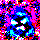

In [46]:
img_arr = np.reshape(l0a.value, IMG_SHAPE).astype(np.uint8)
display(PIL.Image.fromarray(img_arr))

In [28]:
print(np.min(l1z.value), np.max(l1z.value))

-7151.369775578802 12349.772123873583
